<a href="https://colab.research.google.com/github/Heibattttt/A5MOVIE/blob/main/Copy_of_HM4_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Recommendation System with LSH**



### **1.1 Data Preparation**

The following steps are data preparation, to ensure that our dataset is clean and structured in a way that makes it ready for building recommendation system or performing any other analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from collections import Counter
import umap

In [2]:
rating = pd.read_csv('data/rating.csv')
movie = pd.read_csv('data/movie.csv')

In [3]:
print(rating.head())
print(movie.head())

   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
print(rating.info())  # Get info on null values and data types
print(movie.info())   # Same for movies dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None


In [5]:
print(rating.describe())  # Get statistical details about ratings
print(movie['genres'].value_counts())

             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00
genres
Drama                                                  4520
Comedy                                                 2294
Documentary                                            1942
Comedy|Drama                                           1264
Drama|Romance                                          1075
                                                       ... 
Action|Comedy|Crime|Western                               1
Action|Fantasy|Sci-Fi|Thriller                            1
Action|Drama|Fantasy|Horror|Mystery|Sci-Fi|Thriller       1
Action|Drama|Fantasy|

In [6]:
rating['timestamp'] = pd.to_datetime(rating['timestamp']) #to ensure a correct format for timestamps


In [7]:
# Merging the rating data with the movie data
movie_rating = pd.merge(rating, movie, on='movieId')

# Clean up genres
movie_rating['clean_genres'] = movie_rating['genres'].str.replace('|', ' ', regex=False)

print(movie_rating[['clean_genres']].head())


                             clean_genres
0              Adventure Children Fantasy
1  Adventure Drama Fantasy Mystery Sci-Fi
2                 Mystery Sci-Fi Thriller
3                        Mystery Thriller
4                  Crime Mystery Thriller


In [8]:
movie_rating = pd.merge(rating, movie, on='movieId', how='inner')

movie_rating.head()

userId  movieId  rating           timestamp  \
0       1        2     3.5 2005-04-02 23:53:47   
1       1       29     3.5 2005-04-02 23:31:16   
2       1       32     3.5 2005-04-02 23:33:39   
3       1       47     3.5 2005-04-02 23:32:07   
4       1       50     3.5 2005-04-02 23:29:40   

                                               title  \
0                                     Jumanji (1995)   
1  City of Lost Children, The (Cité des enfants p...   
2          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3                        Seven (a.k.a. Se7en) (1995)   
4                         Usual Suspects, The (1995)   

                                   genres  
0              Adventure|Children|Fantasy  
1  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
2                 Mystery|Sci-Fi|Thriller  
3                        Mystery|Thriller  
4                  Crime|Mystery|Thriller

In [9]:
n_ratings = len(rating)
n_movies = len(rating['movieId'].unique())
n_users = len(rating['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 20000263
Number of unique movieId's: 26744
Number of unique users: 138493
Average ratings per user: 144.41
Average ratings per movie: 747.84


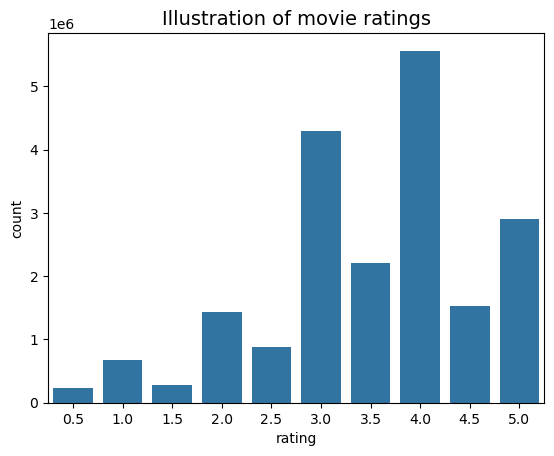

In [10]:
sns.countplot(x='rating', data=rating)
plt.title("Illustration of movie ratings", fontsize=14)
plt.show()

In [11]:
# general rating behavior of the users in the dataset
print(f"Mean rating: {round(rating['rating'].mean(), 2)}")
mean_rating = rating.groupby('movieId')[['rating']].mean()
print(f"Mean rating per user: {round(mean_rating['rating'].mean(), 2)}")

Mean rating: 3.53
Mean rating per user: 3.13


In [12]:
#number of rating times for each MovieId
rating['movieId'].value_counts()


movieId
296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
125545        1
78873         1
112907        1
112909        1
110510        1
Name: count, Length: 26744, dtype: int64

In [13]:
#The 10 Most rated movies.
movie_rating = rating.merge(movie, on='movieId')
movie_rating['title'].value_counts()[0:10]

title
Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Name: count, dtype: int64

In [14]:
#The lowest rated movie.
mean_rating = rating.groupby('movieId')[['rating']].mean()
lowest_rated = mean_rating['rating'].idxmin()
movie.loc[movie['movieId'] == lowest_rated]

movieId            title genres
5706     5805  Besotted (2001)  Drama

In [15]:
#The highest rated movie.
mean_rating = rating.groupby('movieId')[['rating']].mean()
highest_rated = mean_rating['rating'].idxmax()
movie.loc[movie['movieId'] == highest_rated]

movieId                                          title  \
9007    26718  Life On A String (Bian chang Bian Zou) (1991)   

                               genres  
9007  Adventure|Drama|Fantasy|Musical

# **1.2 Minhash Signatures**

### **> MinHash function**

In [16]:
import pandas as pd
import numpy as np
import random

class MinHashRecommender:
    def __init__(self, num_hashes=100):
        """
        Initialize MinHash recommender with configurable hash functions

        Args:
            num_hashes (int): Number of hash functions to use
        """
        self.num_hashes = num_hashes
        self.hash_functions = None
        self.user_signatures = None

    def generate_hash_functions(self, max_value):
        """
        Generate universal hash functions

        Args:
            max_value (int): Maximum value to use in hash function generation
        """
        # Use cryptographically secure prime
        prime = 2**61 - 1  # Mersenne prime

        self.hash_functions = []
        for _ in range(self.num_hashes):
            # More robust hash function generation
            a = random.randint(1, prime - 1)
            b = random.randint(0, prime - 1)
            self.hash_functions.append((a, b, prime))
    def compute_signatures(self, user_sets):
        """
        Compute MinHash signatures for user sets

        Args:
            user_sets (dict): Dictionary of user IDs to sets of items

        Returns:
            dict: MinHash signatures for each user
        """
        if not self.hash_functions:
            raise ValueError("Hash functions not generated. Call generate_hash_functions first.")

        signatures = {}
        for user_id, item_set in user_sets.items():
            user_signature = []
            for a, b, prime in self.hash_functions:
                # Compute minimum hash for the set
                min_hash = min((a * item + b) % prime for item in item_set)
                user_signature.append(min_hash)
            signatures[user_id] = user_signature

        self.user_signatures = signatures
        return signatures

    def compute_similarity(self, signature1, signature2):
        """
        Estimate Jaccard similarity using MinHash signatures

        Args:
            signature1 (list): MinHash signature for first set
            signature2 (list): MinHash signature for second set

        Returns:
            float: Estimated Jaccard similarity
        """
        # Count matching hash values
        matches = sum(s1 == s2 for s1, s2 in zip(signature1, signature2))
        return matches / len(signature1)

    def get_most_similar_users(self, target_user, top_k=5):
        """
        Find most similar users to a target user

        Args:
            target_user (int): User ID to find similar users for
            top_k (int): Number of similar users to return

        Returns:
            list: Top K most similar users
        """
        if not self.user_signatures:
            raise ValueError("Signatures not computed. Call compute_signatures first.")

        similarities = []
        target_signature = self.user_signatures[target_user]

        for user_id, signature in self.user_signatures.items():
            if user_id != target_user:
                similarity = self.compute_similarity(target_signature, signature)
                similarities.append((user_id, similarity))

        # Sort and return top K similar users
        return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]



def main():

    # Load rating data
    rating = pd.read_csv('data/rating.csv')

    # Convert to user-movie sets
    user_movies = rating.groupby('userId')['movieId'].apply(set).to_dict()

    # Initialize and run MinHash
    recommender = MinHashRecommender(num_hashes=100)
    recommender.generate_hash_functions(max(rating['movieId']))
    recommender.compute_signatures(user_movies)

    # Find most similar users to user 1
    similar_users = recommender.get_most_similar_users(1)
    print("Most similar users to user 1:")
    for user, similarity in similar_users:
        print(f"User {user}: Similarity = {similarity:.4f}")

if __name__ == "__main__":
    main()

Most similar users to user 1:
User 42841: Similarity = 0.2700
User 135848: Similarity = 0.2700
User 11024: Similarity = 0.2600
User 13605: Similarity = 0.2500
User 23712: Similarity = 0.2500


## **1.3 Locality-Sensitive Hashing (LSH)**


In [17]:
import numpy as np
import hashlib
from collections import defaultdict
import pandas as pd
import random

# 1. Bucket Creation
# Number of bands and hash functions per band
num_bands = 20  # You can adjust this number
num_hashes = 100  # Number of hash functions used in the MinHash

# Helper function to split the signature into bands
def split_into_bands(signature, num_bands, num_hashes):
    band_size = num_hashes // num_bands
    bands = []

    # Split the signature into bands (each band of size `band_size`)
    for i in range(num_bands):
        band = tuple(signature[i * band_size:(i + 1) * band_size])
        bands.append(band)

    return bands

# Load rating data to generate user signatures
rating = pd.read_csv('data/rating.csv')
user_movies = rating.groupby('userId')['movieId'].apply(set).to_dict()

recommender = MinHashRecommender(num_hashes=num_hashes)
recommender.generate_hash_functions(max(rating['movieId']))
user_signatures = recommender.compute_signatures(user_movies) # define of user_signatures

#  Apply banding to one user's signature
user_id = 1
signature = user_signatures[user_id]  # Get the MinHash signature of user 1
bands = split_into_bands(signature, num_bands, num_hashes)

# Check the bands for this user
print(f"Bands for user {user_id}: {bands}")


# Hash function to hash a band
def hash_band(band):

    return hashlib.md5(str(band).encode('utf8')).hexdigest()

# Hash each band and place users in buckets
def create_buckets(user_signatures, num_bands, num_hashes):
    buckets = defaultdict(list)

    for user_id, signature in user_signatures.items():
        # Split the signature into bands
        bands = split_into_bands(signature, num_bands, num_hashes)

        # For each band, hash it and put the user into the corresponding bucket
        for i, band in enumerate(bands):
            band_hash = hash_band(band)
            buckets[band_hash].append(user_id)

    return buckets

# Create the buckets for all users
buckets = create_buckets(user_signatures, num_bands, num_hashes)

# Debugging Tip: Check a few bucket contents to verify users are grouped together
for bucket_id, users in list(buckets.items())[:5]:  # Check the first 5 buckets
    print(f"Bucket {bucket_id}: {users}")

# 2. Query function to find similar users for a given user

def find_similar_users(query_user_id, user_signatures, buckets, num_bands, num_hashes):
    # Get the MinHash signature for the query user
    query_signature = user_signatures[query_user_id]

    # Split the query user's signature into bands
    query_bands = split_into_bands(query_signature, num_bands, num_hashes)

    similar_users = set()

    # For each band, check the bucket and find users in the same bucket
    for band in query_bands:
        band_hash = hash_band(band)

        # If the band hash exists in the buckets, add the users to the similar_users set
        if band_hash in buckets:
            similar_users.update(buckets[band_hash])

    # Remove the query user from the similar users (since a user is most similar to themselves)
    similar_users.discard(query_user_id)

    return similar_users

#  Find similar users for user 1
query_user_id = 1
similar_users = find_similar_users(query_user_id, user_signatures, buckets, num_bands, num_hashes)

print(f"Similar users for user {query_user_id}: {similar_users}")

Bands for user 1: [(5779143694873638, 1408770999979554, 12691597871251574, 25935035032371924, 2949618305353252), (2150745074368187, 10773682699390650, 3269128437789079, 1484691856778759, 4977883967530550), (350155657729921, 1134336805738420, 16346592064754596, 17648434386512081, 9129215073650989), (21849560120317458, 37858719969735850, 3570824732269723, 22574415885572727, 266827040399423), (3652067066613666, 25330202098008198, 4689979588700526, 2707093684428639, 1473874268069431), (5919401490512808, 9190112249472826, 6216919921808385, 2089512995396387, 17026049641105779), (6146226484675739, 13665570913137511, 1676431817172443, 5173182513809812, 3646203334406630), (32022369452334639, 24745679031465586, 6812922796574855, 10153695803604693, 2851099828070205), (2008949031343707, 3154572545405196, 8912052795465415, 566119912020188, 38151726277113867), (9770964786882279, 4054625334857445, 2551700921770796, 13117848777699984, 25236275857442087), (16016022384182049, 5980323011092288, 697291406

In [28]:
import pandas as pd
import numpy as np

# rating DataFrame with user ratings
rating_movie = {
    'userId': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'movieId': ['Inception', 'Titanic', 'Avatar', 'Inception', 'Matrix', 'Toy Story', 'Titanic', 'Avatar', 'Shrek'],
    'rating': [4.5, 4.2, 2.8, 4.6, 3.9, 4.7, 3.8, 4.3, 4.1]
}
rating_df = pd.DataFrame(rating_movie)

# Create a user-item matrix
user_movie_matrix = rating_df.pivot(index='userId', columns='movieId', values='rating')

# Given similar users based on MinHash or LSH (in practice, you would use an actual similarity measure)
user_similarities = {
    1: {2: 0.9, 3: 0.7},  # User 1 is most similar to User 2 (0.9) and User 3 (0.7)
    2: {1: 0.9, 3: 0.6},
    3: {1: 0.7, 2: 0.6}
}

# Function to get the most similar users
def get_similar_users(user_id, user_similarities, top_n=2):
    """Get the top N similar users to a given user."""
    if user_id not in user_similarities:
        return []
    return sorted(user_similarities[user_id].items(), key=lambda x: x[1], reverse=True)[:top_n]

# Function to recommend movies based on common ratings and top-rated movies
def recommend_movies(user_id, user_movie_matrix, user_similarities, top_n_similar_users=2, top_n_recommendations=5):
    # Step 1: Get the most similar users
    similar_users = get_similar_users(user_id, user_similarities, top_n=top_n_similar_users)

    # Extract user IDs of the most similar users
    similar_user_ids = [user for user, _ in similar_users]

    # Step 2: Find common movies rated by both the target user and the similar users
    user_movies = set(user_movie_matrix.loc[user_id].dropna().index)
    common_movies = set(user_movies)

    for sim_user in similar_user_ids:
        sim_user_movies = set(user_movie_matrix.loc[sim_user].dropna().index)
        common_movies.intersection_update(sim_user_movies)

    # Step 3: Calculate the average rating of common movies
    common_movie_ratings = []
    if common_movies:
        for movie in common_movies:
            ratings_for_movie = [user_movie_matrix.loc[sim_user, movie] for sim_user in similar_user_ids]
            avg_rating = np.mean(ratings_for_movie)
            common_movie_ratings.append((movie, avg_rating))

    # Sort common movies by average rating in descending order
    common_movie_ratings.sort(key=lambda x: x[1], reverse=True)

    # Step 4: Create the recommendations list (ensure it's at least 5 items)
    recommendations = []

    # Add common movie recommendations first (sorted by average rating)
    recommendations.extend(common_movie_ratings[:top_n_recommendations])

    # Ensure no duplicate movies (we only want unique movie recommendations)
    recommended_movies_set = set([movie for movie, _ in recommendations])

    # If fewer than 5 recommendations, add top-rated movies from the most similar user
    if len(recommendations) < top_n_recommendations:
        most_similar_user = similar_user_ids[0]
        top_rated_movies = user_movie_matrix.loc[most_similar_user].dropna().sort_values(ascending=False).head(top_n_recommendations - len(recommendations))

        # Add top-rated movies from most similar user, ensuring no duplicates
        for movie, rating in top_rated_movies.items():
            if movie not in recommended_movies_set:  # Ensure no duplicate
                recommendations.append((movie, rating))
                recommended_movies_set.add(movie)  # Add to the set of recommended movies

    # If still fewer than 5, try adding movies from the next most similar user
    if len(recommendations) < top_n_recommendations:
        next_similar_user = similar_user_ids[1] if len(similar_user_ids) > 1 else similar_user_ids[0]
        top_rated_movies = user_movie_matrix.loc[next_similar_user].dropna().sort_values(ascending=False).head(top_n_recommendations - len(recommendations))

        # Add top-rated movies from the second most similar user, ensuring no duplicates
        for movie, rating in top_rated_movies.items():
            if movie not in recommended_movies_set:
                recommendations.append((movie, rating))
                recommended_movies_set.add(movie)

    # 5 recommendations
    return recommendations[:top_n_recommendations]

#Recommend movies for user X
user_id = 2
if user_id not in user_movie_matrix.index:
    print(f"User {user_id} does not exist")
else:
    recommended_movies = recommend_movies(user_id, user_movie_matrix, user_similarities)

# Display the recommended movies
print(f"Recommended movies for user {user_id}:")
for movie, rating in recommended_movies:
    print(f"Movie: {movie}, Rating: {rating:.1f}")

Recommended movies for user 2:
Movie: Inception, Rating: 4.5
Movie: Titanic, Rating: 4.2
Movie: Avatar, Rating: 2.8
Movie: Shrek, Rating: 4.1


In [29]:
# Load each CSV file into a separate DataFrame
movie_scores = pd.read_csv('data/genome_scores.csv', header='infer')

movie_tags = pd.read_csv('data/genome_tags.csv', header='infer')

movie = pd.read_csv('data/movie.csv', header='infer')

rating = pd.read_csv('data/rating.csv', header='infer')

tag = pd.read_csv('data/tag.csv', header='infer')

In [30]:
# Print the first two rows of each DataFrame and the number if null values
print("movie_scores:")
print(movie_scores.head(2), f"\n\nnumber of NaN values:\n{movie_scores.isna().sum()}\n")


print("\nmovie_tags:")
print(movie_tags.head(2), f"\n\nnumber of NaN values:\n{movie_tags.isna().sum()}\n")


print("\nmovie:")
print(movie.head(2), f"\n\nnumber of NaN values:\n{movie.isna().sum()}\n")


print("\nrating:")
print(rating.head(2), f"\n\nnumber of NaN values:\n{rating.isna().sum()}\n")


print("\ntag:")
print(tag.head(2), f"\n\nnumber of NaN values:\n{tag.isna().sum()}\n")
tag = tag.dropna()

movie_scores:
   movieId  tagId  relevance
0        1      1      0.025
1        1      2      0.025 

number of NaN values:
movieId      0
tagId        0
relevance    0
dtype: int64


movie_tags:
   tagId           tag
0      1           007
1      2  007 (series) 

number of NaN values:
tagId    0
tag      0
dtype: int64


movie:
   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy 

number of NaN values:
movieId    0
title      0
genres     0
dtype: int64


rating:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16 

number of NaN values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


tag:
   userId  movieId          tag            timestamp
0      18     4141  Mark Waters  2009-04-24 18:19:40
1   

In [31]:
print("\ntag:")
print(f"\n\nnumber of NaN values:\n{tag.isna().sum()}\n")


tag:


number of NaN values:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64



Some files have NaN values, so we remove them to have a complete Dataset

### **1.1 Adding the movie ID and averere rating**

In [32]:
features = pd.DataFrame()

features["movieId"] = movie["movieId"]

# Step 1: Genres
# Transform genres into a list of genres, even for single genres without '|'
features['genres_list'] = movie['genres'].apply(lambda x: x.split('|') if '|' in x else [x])

# Step 2: Average Ratings
average_rating = rating.groupby('movieId')['rating'].mean().reset_index()
average_rating.columns = ["movieId", "averege_rating"]
ratings_count = rating.groupby('movieId').size().reset_index(name='rating_count')
average_rating["number_of_rating"] = ratings_count.drop(columns="movieId")
tmp_merge = features.merge(average_rating, on="movieId", how = "outer")

# cecking if there are mismaching values:
print(f"Cecking mismatching values:\n{tmp_merge.isna().sum()}")
# since there are missing values in the average_rating column it means that some movies do not have any rating and we 
# can fix it by giving it a average of -1 to differentiate it from an averege of 0. the number of ratings will be set as 0 nevertheless as it recived 0 reviews
print(f"\nThe number of mismatched movies is in fact: {len(set(features.movieId)^set(average_rating.movieId))}\n")

mismatched_ratings = list(set(features.movieId)^set(average_rating.movieId))
mismatched_ratings = {"movieId" : mismatched_ratings, "averege_rating" : [-1]*len(mismatched_ratings),
                      "number_of_rating" : [0]*len(mismatched_ratings)}
mismatched_ratings = pd.DataFrame.from_dict(mismatched_ratings)
average_rating = pd.concat([average_rating, mismatched_ratings], ignore_index= True)

features = features.merge(average_rating, on="movieId", how = "outer")
# cecking if there are mismaching values:
print(f"\nAfter adding the missing averages with a score of -1\nThe missing values are:\n{features.isna().sum()}")


Cecking mismatching values:
movieId               0
genres_list           0
averege_rating      534
number_of_rating    534
dtype: int64

The number of mismatched movies is in fact: 534


After adding the missing averages with a score of -1
The missing values are:
movieId             0
genres_list         0
averege_rating      0
number_of_rating    0
dtype: int64


Makeing the generes a one hot vector as it is easier to work with than with the words, therfore for now we create a nupy array of binary values to store the information

In [33]:
# Transforming the genres list into a fixed-length binary vector
genere_set = set()
for gener_list in features.genres_list:
    genere_set |= set(gener_list)

genere_vocab = dict(zip(genere_set, range(len(genere_set))))  # Mapping each genre to an index

# Create a binary encoded representation for each row
coded_genere = []
for gener_list in features.genres_list:
    one_line_encoded_genere = [0] * len(genere_vocab)  # Initialize a binary vector with zeros
    for genere in gener_list:
        one_line_encoded_genere[genere_vocab[genere]] = 1  # Mark 1 for each genre in the list
    coded_genere.append(one_line_encoded_genere)

# Replace the column with the new binary-encoded lists
features["genres_list"] = coded_genere


print(f"Dataframe after encoding the generes as a boolean vector: \n{features.head(2)}")


Dataframe after encoding the generes as a boolean vector: 
   movieId                                        genres_list  averege_rating  \
0        1  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...        3.921240   
1        2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...        3.211977   

   number_of_rating  
0             49695  
1             22243  


### **1.2 Adding the most relevant and most common tag**

#### *preparing the data to get the relevance from the tags*

In [34]:
# Setp 3: Most relevant and most common tag given to each movie


tag_given = tag.groupby("movieId")["tag"].apply(list).reset_index()

tag_given["total_tag_count"] = tag_given.tag.apply(lambda x: len(x))

# here we can see that there are some movie that do not have any tag associated with them.
# in order to keep the data and use it we generate a dataframe that diplay the empty values
# for these movies and we add it to the tag dataframe.
tmp_merge = features.merge(tag_given, on="movieId", how = "outer")
print(f"Cecking mismatching values:\n{tmp_merge.isna().sum()}")
print(f"\nIn fact the mismatching values are: {len(set(tag_given.movieId) ^ set(features.movieId))}")

# creatig the dataframe of missing movieIds
movie_with_no_tag_list = list(set(tag_given.movieId) ^ set(features.movieId))

movie_with_no_tag = {
    "movieId": movie_with_no_tag_list,
    "tag": [["no_tag"] for _ in range(len(movie_with_no_tag_list))],
    "total_tag_count": [0] * len(movie_with_no_tag_list),
}
# dataframe of movies with no tags
movie_with_no_tag = pd.DataFrame.from_dict(data=movie_with_no_tag)
tag_given = pd.concat([tag_given, movie_with_no_tag], ignore_index= True)

features = features.merge(tag_given, on="movieId", how = "outer")
print(f"\nCecking mismatching values after filling missing tags with \"no_tag\":\n{features.isna().sum()}\n\n")

Cecking mismatching values:
movieId                0
genres_list            0
averege_rating         0
number_of_rating       0
tag                 7733
total_tag_count     7733
dtype: int64

In fact the mismatching values are: 7733

Cecking mismatching values after filling missing tags with "no_tag":
movieId             0
genres_list         0
averege_rating      0
number_of_rating    0
tag                 0
total_tag_count     0
dtype: int64




#### *preparing a map from the tags to the relevance score*

In [35]:
# to get the tag relevance from the tag as text we merge the tagId to relevance score witht the tag to tagId on tagId 
# and therfore we have a direct map from tag to relevance score

tag_to_score_df = movie_scores.merge(movie_tags, on= "tagId", how="outer")
print(f"missing values in the Dataframe that connects tags to relevance:\n{tag_to_score_df.isna().sum()}")

missing values in the Dataframe that connects tags to relevance:
movieId      0
tagId        0
relevance    0
tag          0
dtype: int64


##### *cecking if all the movies in features are present in the tag_to_score_df to prevent mismatches*

In [36]:
mismaching_movies = list(set(features.movieId)^set(tag_to_score_df.movieId))
print(f"Number of mismatched moovies :{len(mismaching_movies)}")
print(f"\nTo trace the mismatching values we sum the boolean values obtained form iterting over each\ndataframe and ceching if it is in the missmatch list\n")
print(f"mismatches in the feature dataframe : {features.movieId.isin(mismaching_movies).sum()}\n")
print(f"mismatches in the tag to score dataframe : {tag_to_score_df.movieId.isin(mismaching_movies).sum()}\n")


Number of mismatched moovies :16897

To trace the mismatching values we sum the boolean values obtained form iterting over each
dataframe and ceching if it is in the missmatch list

mismatches in the feature dataframe : 16897

mismatches in the tag to score dataframe : 0



This means that there are some films that have no tag relevance information. At this moment, the movies we are analyzing are 27,278, and from those, 16,897 films that don't have this info represent a huge portion of missing information. To fill this with any value would mean strongly altering the distribution shape and therefore invalidating the analysis. Nevertheless, removing those movies would result in a huge loss of data.  
We decided that the loss of data, even though it is substantial, is the preferred method as it preserves the validity of the analysis.

In [37]:
features = features[~features.movieId.isin(mismaching_movies)]
print(f"After remoing the mismathing values the resulting df shape is: {features.shape}")

After remoing the mismathing values the resulting df shape is: (10381, 6)


#### *retriving the highest relevance tag and the common relevance tag*
also computing the average relevance for each movie

The DF features contain the list of all the tags and the list of unique tags.
The DF tag_to_score_df contains the information of the tag relevance for each tag on each movie.

Some movies have tags that are not coded by the tagId, and therefore those tags do not have a relevance score. To continue with the analysis, a new tag will be added, and its relevance will be set to zero. The added tag will be the same for the movies that did not display a tag. The most common tag will also be removed.

In [38]:

most_relev_tag = []
most_common_tag = []
most_relev_tag_relevance = []
most_common_tag_relevance = []

for index, row in features.iterrows():
    all_tags = list(row.tag)
    movie_id = row.movieId

    # Handle no tags or empty tags
    if "no_tag" in all_tags or len(all_tags) == 0:
        most_relev_tag.append("no_tag")
        most_common_tag.append("no_tag")
        most_relev_tag_relevance.append(0.0)
        most_common_tag_relevance.append(0.0)
        continue

    active_tag_to_relevance_df = tag_to_score_df[(tag_to_score_df["movieId"] == movie_id)]

    # Retrieve the most common tag and its relevance
    common_tag = Counter(all_tags).most_common(1)[0][0]
    common_tag_relevance_series = active_tag_to_relevance_df[active_tag_to_relevance_df["tag"] == common_tag]["relevance"]
    common_tag_relevance = float(common_tag_relevance_series.iloc[0]) if not common_tag_relevance_series.empty else 0.0

    # Find the most relevant tag and its relevance
    unique_tags = list(set(all_tags))
    highest_relevances = active_tag_to_relevance_df[active_tag_to_relevance_df["tag"].isin(unique_tags)].sort_values(by="relevance", ascending=False)

    if highest_relevances.empty:
        highest_rel_tag = "no_tag"
        highest_rel_relevance = 0.0
    else:
        highest_rel_tag = highest_relevances.iloc[0]["tag"]
        highest_rel_relevance = float(highest_relevances.iloc[0]["relevance"])

    # Append results
    most_relev_tag.append(highest_rel_tag)
    most_common_tag.append(common_tag)
    most_relev_tag_relevance.append(highest_rel_relevance)
    most_common_tag_relevance.append(common_tag_relevance)

# Assign results to DataFrame columns
features["common_tag"] = most_common_tag
features["relevant_tag"] = most_relev_tag
features["common_tag_relevance"] = most_common_tag_relevance
features["relevant_tag_relevance"] = most_relev_tag_relevance

# Output results
print(f"----------Completed dataframe overview:\n{features.head(2)}\n\n----------Verifying integrity of the almost finished dataframe:\n{features.isna().sum()}")


----------Completed dataframe overview:
   movieId                                        genres_list  averege_rating  \
0        1  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...        3.921240   
1        2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...        3.211977   

   number_of_rating                                                tag  \
0             49695  [Watched, computer animation, Disney animated ...   
1             22243  [time travel, adapted from:book, board game, c...   

   total_tag_count      common_tag relevant_tag  common_tag_relevance  \
0              436           Pixar         toys                   0.0   
1              123  Robin Williams    adventure                   0.0   

   relevant_tag_relevance  
0                 0.99925  
1                 0.98100  

----------Verifying integrity of the almost finished dataframe:
movieId                   0
genres_list               0
averege_rating            0
number_of_rating          0
tag         

#### *transforming the generes values into usable information*
this is done by transforming the one hot vector of all the generes for each movie to each generes for each movie\
giving each generes it's onw column

In [39]:
# Step 1: Expand the 'genres_list' into separate columns
expanded_genres = features['genres_list'].apply(pd.Series)

# Step 2: Map the genre names to their corresponding names in 'genere_vocab'
expanded_genres = expanded_genres.map(lambda x: genere_vocab.get(x, x))
expanded_genres.columns = list(genere_vocab.keys())
# Step 3: Concatenate the expanded columns back to the original DataFrame
final_df = pd.concat([features, expanded_genres], axis=1)

# Display the result
print(f"Final version of the dataframe:\n{final_df.head(1)}")


Final version of the dataframe:
   movieId                                        genres_list  averege_rating  \
0        1  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...         3.92124   

   number_of_rating                                                tag  \
0             49695  [Watched, computer animation, Disney animated ...   

   total_tag_count common_tag relevant_tag  common_tag_relevance  \
0              436      Pixar         toys                   0.0   

   relevant_tag_relevance  ...  IMAX  Horror  Adventure  Western  Children  \
0                 0.99925  ...     0       0          1        0         1   

   Thriller  (no genres listed)  Mystery  Film-Noir  Fantasy  
0         0                   0        0          0        1  

[1 rows x 30 columns]


#### *If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.*

Since not all of the input columns are descriptive values, to represent them we need to add other variables to the dataframe to describe the categorical value. In order to describe the most common and most relevant tags, we use the corresponding relevance score. We decided to use these variables as we believe that this value represents user review quality, since films that have a lower relevance score most likely have conflicting tags. Therefore, movies with similar tag relevance have a similar user response to the film.  

For the genres variable, we used a one-hot vector for each film to represent the genre given to it. Later, we used it to create one column for each genre so we can compare genre distribution across movies.  

The average rating column is already a descriptive column, as it shows the quality of the film as perceived by the user. Nevertheless, this value is heavily biased by the number of ratings.

### **2.2 Choosing the variables for the clustering**

##### *1) What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?*

To prevent the range of the values from influencing the clustering process, we scale all the values to a standardized range.  
The range differences can create imaginary differences that normalizing can prevent.

In [40]:

# normalizing the averege rateing based on the number of reviews
min_val = final_df['number_of_rating'].min()
max_val = final_df['number_of_rating'].max()

final_df['number_of_rating_normalized'] = (final_df['number_of_rating'] - min_val) / (max_val - min_val)

final_df["averege_rating"] = final_df["averege_rating"] * final_df['number_of_rating_normalized']

# dropping the categorical column to work only on the descriptive data 
# genere_list is dropped as it was a leaning data column to hold the info before adding it as separate columns
# we also remove the unormalized number of ratieng as we altready added the normalized one and it would 
# count two times
col_to_drop = ["movieId","genres_list", "tag", "common_tag", "relevant_tag", "number_of_rating"]

new_row_names = final_df.movieId.to_list()

final_df = final_df.drop(columns=col_to_drop, errors='ignore')

final_df.index = new_row_names

final_df.head(1)


averege_rating  total_tag_count  common_tag_relevance  \
1        2.895053              436                   0.0   

   relevant_tag_relevance  Musical  Action  Sci-Fi  Documentary  Crime  \
1                 0.99925        0       0       0            0      0   

   Animation  ...  Horror  Adventure  Western  Children  Thriller  \
1          1  ...       0          1        0         1         0   

   (no genres listed)  Mystery  Film-Noir  Fantasy  \
1                   0        0          0        1   

   number_of_rating_normalized  
1                       0.7383  

[1 rows x 25 columns]

In [41]:
features = final_df.copy()
print(final_df.isna().sum())

averege_rating                 0
total_tag_count                0
common_tag_relevance           0
relevant_tag_relevance         0
Musical                        0
Action                         0
Sci-Fi                         0
Documentary                    0
Crime                          0
Animation                      0
Comedy                         0
Drama                          0
Romance                        0
War                            0
IMAX                           0
Horror                         0
Adventure                      0
Western                        0
Children                       0
Thriller                       0
(no genres listed)             0
Mystery                        0
Film-Noir                      0
Fantasy                        0
number_of_rating_normalized    0
dtype: int64


The data that we chose to use is of different types and lies in different ranges. To prevent noise from these differences, a simple process of data normalization is performed. Using the min-max normalization method, all values now lie within the same range and are therefore easier to compare.

In [42]:
scaled_data = minmax_scale(final_df)
scaled_data.shape

(10381, 25)

Since the number of columns is excessive for visualizing clustering, some form of dimensionality reduction must be applied.  
Dimensionality reduction is a process used to concentrate relevant information into a more convenient dimensional space. In our case, visualizing movies would be impossible as there are more than 20 dimensions in which data must be represented. Since we are unable to efficiently visualize and cluster this information in a human-compatible way, we must reduce the dimensions in which we plot the data.  

To keep the information from all the features while making the data compatible with a 2D projection, we can use dimensionality reduction techniques. These techniques are designed to retain as much information as possible in the smallest number of dimensions. Therefore, by utilizing the first two dimensions from a dimensionality reduction, we can visualize the data in 2D with respect to the highest possible variance.

In [43]:
# Perform dimensionality reduction, PCA
pca = PCA(n_components=2)  # Select the number of components
pca_components = pca.fit_transform(scaled_data)

pca_components


array([[ 0.92338296, -0.5464276 ],
       [ 0.22190106, -0.50658586],
       [ 0.85320426,  0.14034164],
       ...,
       [ 0.54505672, -0.43555698],
       [-0.20103743,  0.78126306],
       [-0.16847808, -0.69732783]])

The output of the PCA analysis provides a value for each film (the score of the main component), reflecting its position along the main components. These components represent combinations of the original variables, weighted by their importance in explaining the variance of the data.

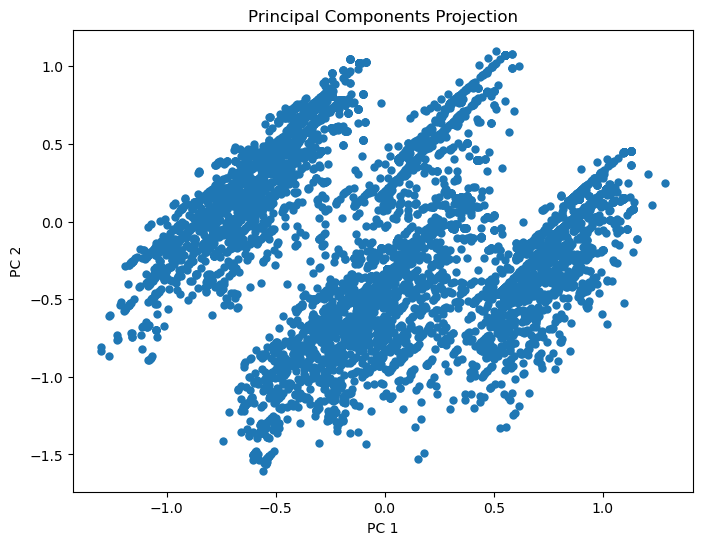

In [44]:
# Visualize PCA results
plt.figure(figsize=(8, 6))
plt.scatter(x = pca_components[:, 0], y = pca_components[:, 1], linewidths= 0.001)
plt.title('Principal Components Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


In [45]:
# Create a DataFrame for PCA components
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Variance Explained:", cumulative_variance)


Explained Variance Ratio: [0.16474131 0.14478855]
Cumulative Variance Explained: [0.16474131 0.30952986]


Here we can see that not much of the variance of the dataset has been collected from these computed components, most likely our features are weakly correlated, and therfore PCA won't work effectively. A correlation matrix will give more insight in the reason why the variance explained is so low.

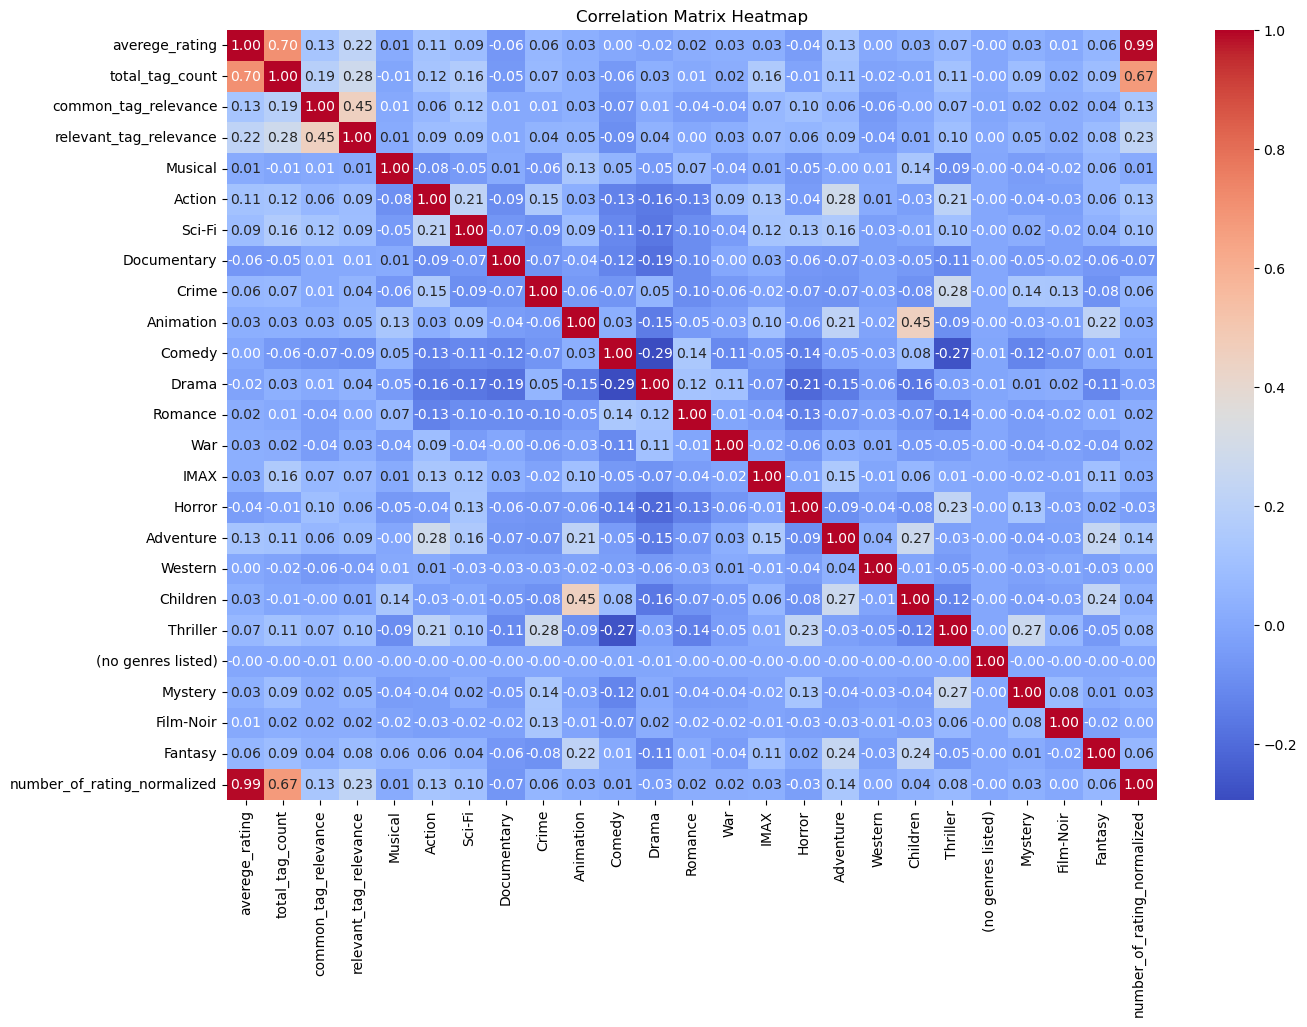

In [46]:

correlation_matrix = pd.DataFrame(final_df).corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation matrix shows that the features in the dataset are not strongly correlated in a linear sense. This suggests that linear dimensionality reduction techniques, like PCA, might not capture all of the underlying structure in the data. Non-linear dimensionality reduction methods could potentially work better by uncovering more complex relationships between the features.

c:\Users\Xxqas\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


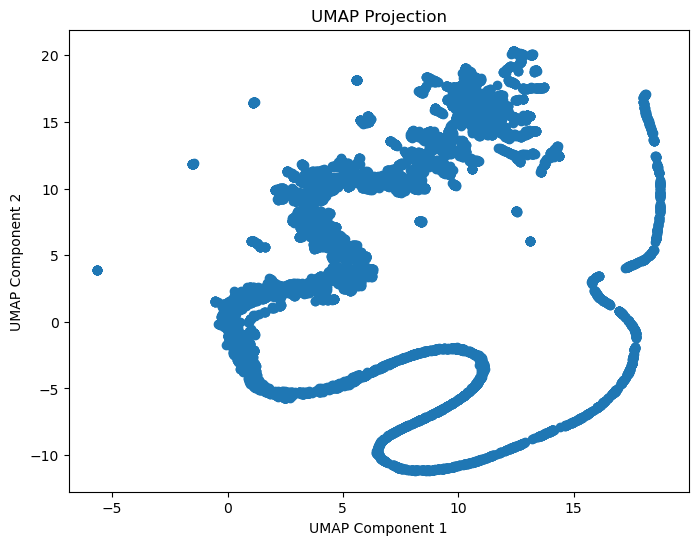

In [47]:
# Assuming final_df is your pre-scaled data
umap_model = umap.UMAP(n_components=2, random_state=420)
umap_components = umap_model.fit_transform(final_df)

# Plot the UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_components[:, 0], umap_components[:, 1])
plt.title("UMAP Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

The UMAP projection displays a two-dimensional view of the data after nonlinear dimensionality reduction. This plot reveals one winding curve with clusters of data points, indicating that UMAP managed to preserve some local relationships. The dense lower-left region may represent a cluster of similar data points, while the sparse upper-right region might include outliers or more spread-out data. This suggests that UMAP is capturing nonlinear structures in the data, which linear methods like PCA might miss. The non-uniform distribution of points highlights the method's ability to handle complex data distributions. However, the global structure might be harder to interpret, and further clustering analysis could provide more insights into the quality of the dimensionality reduction.

#### *Final thoughts on dimensionality reductions*

Our goal in this step of the exercise is to prepare the data for clustering; therefore, our decision on which reduction to use is also influenced by the possible result of clustering. The UMAP reduction seems to be more relevant for a real analysis where we want to observe meaningful differences in movies, but it requires different kinds of clustering algorithms to better represent differences in the data, such as DBSCAN (Density-Based Spatial Clustering of Applications with Noise), HDBSCAN (Hierarchical DBSCAN), Agglomerative Clustering (Hierarchical Clustering), and Gaussian Mixture Models (GMM).  
Since our goal is to use the k-means algorithm specifically, it is a better choice to use a linear dimensionality reduction method like PCA, as the result is more compatible with k-means clustering.  
Based on this reasoning, we will use PCA even though it does not hold as much relevant information for describing the films.

## **2.3 Clustering**

1) to determine the correct number of clusters we can use the two most common methods, the elbow metod or the silhouette score.

in order to do either of these methods we have to build a kmeans algorithm as it is a core part of both algorithms.

Converged after 12 iterations.


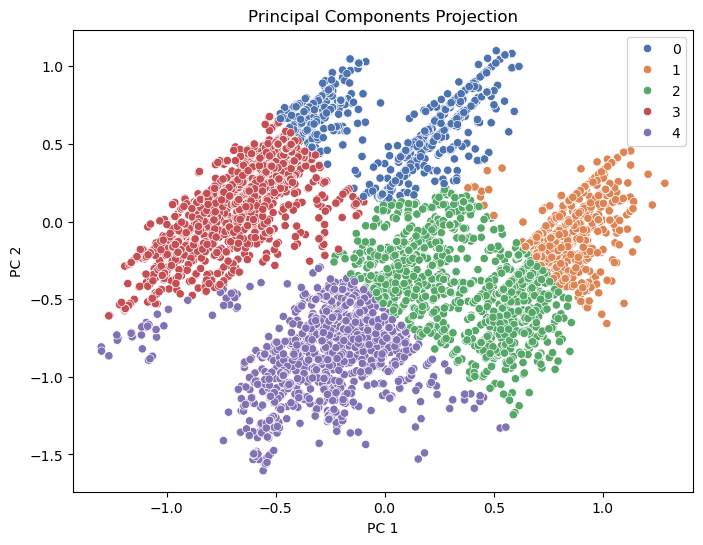

In [48]:

# Initialization
def initialize_centroids(data, K):
    # Randomly select K points from the data as initial centroids
    random_indices = np.random.choice(data.shape[0], K, replace=False)
    return data[random_indices]

# Assignment step
def assign_clusters(data, centroids):
    def assign_point_to_centroid(point):
        # Compute the distance from each point to each center
        distances = np.linalg.norm(centroids - point, axis=1)
        return np.argmin(distances)  # Returns the index of the nearest center
    
    # Apply the assignment step using mapreduce
    return list(map(assign_point_to_centroid, data))

# Update step
def update_centroids(data, labels, K):
    new_centroids = np.zeros((K, data.shape[1]))
    for k in range(K):
        # Compute the new centroid as the mean of points assigned to cluster k
        cluster_points = data[np.array(labels) == k]
        if len(cluster_points) > 0:
            new_centroids[k] = np.mean(cluster_points, axis=0)
    return new_centroids

# K-means algorithm function
def kmeans(data, K, max_iterations=50):
    centroids = initialize_centroids(data, K)
    for i in range(max_iterations):
        # Assignment step
        labels = assign_clusters(data, centroids)
        
        # Update step
        new_centroids = update_centroids(data, labels, K)
        
        # Check for convergence (if centroids don't change)
        if np.all(centroids == new_centroids):
            print(f"Converged after {i+1} iterations.")
            return labels, centroids
        centroids = new_centroids
    print("Clustering terminated due to reaching max iteration") 
    return labels, centroids

# Running K-means on PCA components
K = 5  # Completly random number of clusters

labels, centroids = kmeans(pca_components, K)

# Visualize PCA results with clustering!
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pca_components[:, 0], y = pca_components[:, 1], hue= labels, palette = "deep")
plt.title('Principal Components Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


here we can see that the k-means work perfectly therfore we just need to do the elbow and the siluette methods to discover the optimal number of clusters

#### *Elbow method*
It works by computing the clusters for many different values of k and saving the quality of each clustering. After iterating over the set number of k, we can plot the quality metric called inertia across all the k values. Inertia is the sum of squared differences of all the data points in a cluster. This means that when the clusters are the right fit for the data, adding more clusters will not reduce the inertia by much.

Converged after 2 iterations.
Converged after 20 iterations.
Converged after 15 iterations.
Converged after 16 iterations.
Converged after 14 iterations.
Converged after 26 iterations.
Converged after 23 iterations.
Converged after 10 iterations.
Converged after 13 iterations.
Converged after 25 iterations.


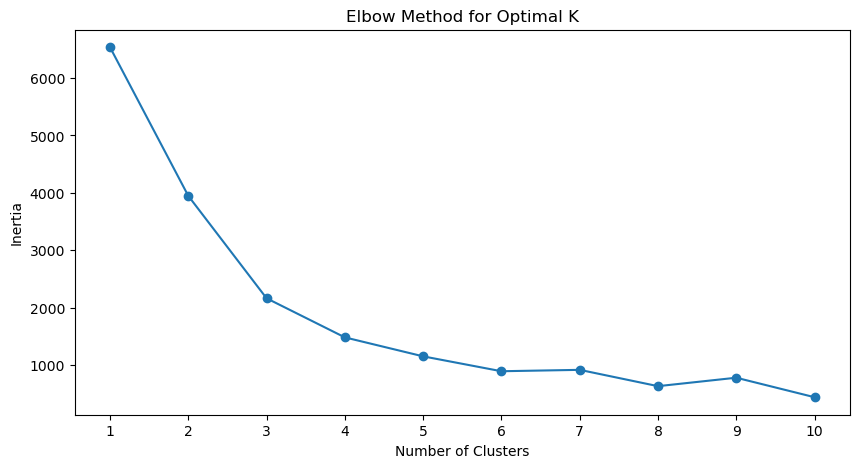

In [49]:
# Function to compute inertia for a given K
def compute_inertia(data, centroids, labels):
    inertia = 0
    for i, point in enumerate(data):  
        centroid = centroids[labels[i]]
        inertia += np.linalg.norm(point - centroid) ** 2
    return inertia

# Running K-means for different K values and calculating inertia
inertia_values = []
for K in range(1, 11):
    labels, centroids = kmeans(pca_components, K)
    inertia = compute_inertia(pca_components, centroids, labels)
    inertia_values.append(inertia)

# Plotting the elbow graph
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1,11))
plt.show()


From this elbow plot we can deduce that the corrct number of clusters is 3 as it it the last step that decreses significantly the inertia of the clusters.

#### *Siluette score*

Converged after 12 iterations.
Converged after 14 iterations.
Converged after 7 iterations.
Converged after 26 iterations.
Converged after 17 iterations.
Converged after 13 iterations.
Converged after 33 iterations.
Converged after 38 iterations.
Converged after 15 iterations.
Converged after 20 iterations.
Converged after 28 iterations.
Converged after 23 iterations.
Converged after 17 iterations.
Converged after 37 iterations.
Converged after 44 iterations.
Converged after 19 iterations.
Converged after 44 iterations.
Clustering terminated due to reaching max iteration
Converged after 49 iterations.


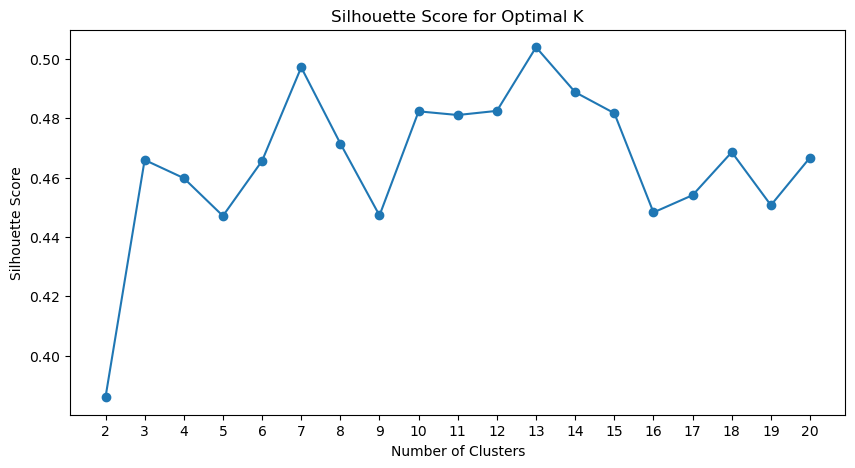

In [50]:
from sklearn.metrics import silhouette_score

# Running K-means for different K values and calculating silhouette score
sil_scores = []
# Silhouette score is undefined for K=1 therfore we will skip it
for K in range(2, 21):  
    labels, centroids = kmeans(pca_components, K)
    sil_score = silhouette_score(pca_components, labels)
    sil_scores.append(sil_score)

# Plotting silhouette scores
plt.figure(figsize=(10,5))
plt.plot(range(2, 21), sil_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2,21))
plt.show()


The silhouette score really changes a lot with the increase in k. This means the model is changing its performance for clustering, and there is no particular trend showing improvement or deterioration. This usually happens when the clusters are not well separated, or the data is not naturally structured into distinct groups. The biggest peaks occur towards k greater than 10, but as we have seen from the elbow plot, we know that k = 3 is also a good clustering value.  
Note that this method is highly unstable and therefore may change values. We chose 10 as it has some robustness as a high value.

Converged after 12 iterations.
Clustering from elbow method!



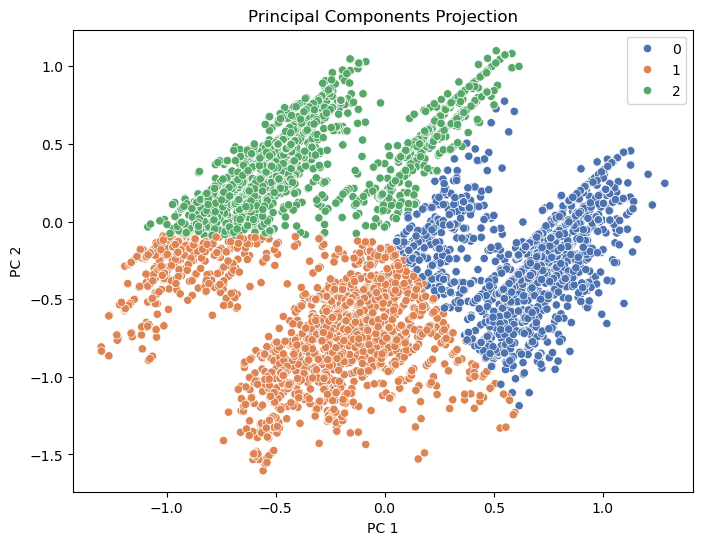

Converged after 13 iterations.
Clustering from Silhouette score!



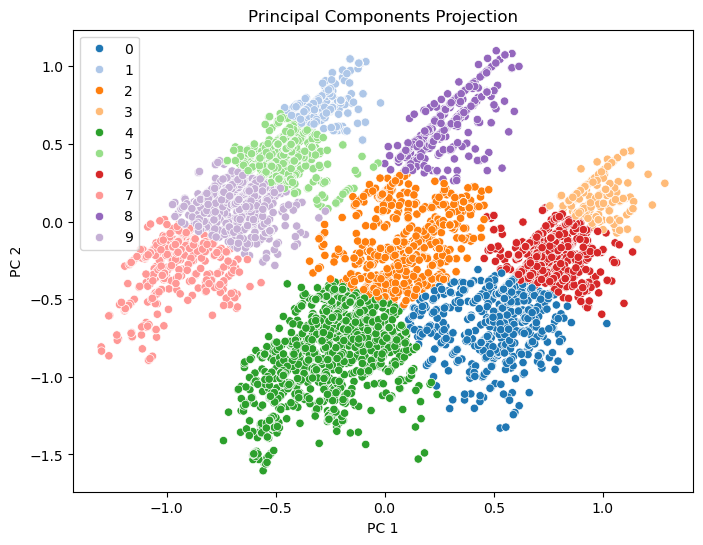

In [51]:
# Running K-means on PCA components
K = 3  # smallest good value

labels, centroids = kmeans(pca_components, K)

# Visualize PCA results with clustering!
print("Clustering from elbow method!\n")
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pca_components[:, 0], y = pca_components[:, 1], hue= labels, palette = "deep")
plt.title('Principal Components Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

K = 10  # best siluette value

labels, centroids = kmeans(pca_components, K)

# Visualize PCA results with clustering!
print("Clustering from Silhouette score!\n")
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pca_components[:, 0], y = pca_components[:, 1], hue= labels, palette = "tab20")
plt.title('Principal Components Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

The clustering results are better analyzed by the silhouette plot and PCA projection. The silhouette scores vary across different values of K, with a noticeable peak at K=10. This could indicate that the structure of the data favors more granular clustering, but the consistent rise and fall may reflect noise or overlap between cluster boundaries. On the other hand, with K=3 (chosen according to the elbow method or based on some a priori hypothesis), the PCA projection shows three quite distinct, well-separated clusters. While K=3 made this representation clear, it came at the risk of over-simplifying the natural complexity of the data. Choosing K=10, from the silhouette method, might give a more fine-grained result that could also be less meaningful or unstable. The balance between interpretability and accuracy depends on the problem context; however, K=3 would appear more robust and easier to interpret based on the PCA plot shown.

#### **Implementing K-means++**

The function for the K-means++ version is almost the same as the normal K-means. The changes occur in the initialization algorithm, as it does not choose centroids randomly but instead selects them based on an adaptive probability, which is determined by the distance from already chosen centroids.

Clustering terminated due to reaching max iteration


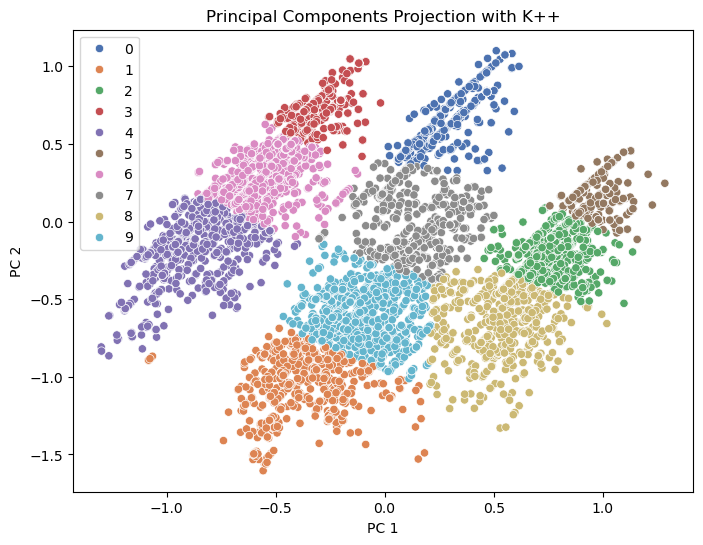

In [52]:
def kmeans_plus_plus_init(data, K):
    centroids = []
    # Choose the first centroid randomly
    centroids.append(data[np.random.choice(range(data.shape[0]))])
    
    for _ in range(1, K):
        # Calculate the distance of each point to the nearest centroid
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
        # Choose the next centroid based on probability proportional to distance squared
        prob = distances ** 2
        prob /= prob.sum()  # Normalize the probabilities
        next_centroid_idx = np.random.choice(range(data.shape[0]), p=prob)
        centroids.append(data[next_centroid_idx])
    
    return np.array(centroids)

# Running  K-means++
def kmeans_plus_plus(data, K, max_iterations=25):
    # the diffrent initiation step
    centroids = kmeans_plus_plus_init(data, K)
    for i in range(max_iterations):

        labels = assign_clusters(data, centroids)
        
        new_centroids = update_centroids(data, labels, K)
        
        if np.all(centroids == new_centroids):
            print(f"Converged after {i+1} iterations.")
            return labels, centroids
        
        centroids = new_centroids

    print("Clustering terminated due to reaching max iteration") 
    return labels, centroids

# Running K-means++ on PCA components
K = 10
labels_pp, centroids_pp = kmeans_plus_plus(pca_components, K)


# Visualize PCA results with clustering!
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pca_components[:, 0], y = pca_components[:, 1], hue= labels_pp, palette = "deep")
plt.title('Principal Components Projection with K++')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

#### *Observations*

We can see that in the normal K-means algorithm, the top-left region of points is split into two parts, whereas in K-means++, it is split into multiple parts. In contrast, the bottom-right region is split into three clusters in K-means, but only two in K-means++.  
Both of these occurrences happen because better starting centroids are chosen. In both cases, the clusters obtained from the normal K-means are of the wrong size: in the top-left, the clusters are unnecessarily small, and in the bottom-right, the clusters are excessively large. With an initialization that can prevent cramped centroids and generally provides better positions for the starting points, a more relevant separation of the data is achieved.

## *Gemini advice*

Response from the LLM:

#### *Recommended Algorithm:* DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together. Unlike distance-based algorithms like K-Means, DBSCAN doesn't require specifying the number of clusters beforehand.\

#### *How it works:*

Core Points: A point is considered a core point if it has a minimum number of points (MinPts) within a specified radius (Eps).   

Density-Reachable Points: A point is density-reachable from a core point if it lies within the Eps radius of that core point.  
Clusters: A cluster is formed by a core point and all points that are density-reachable from it.
Noise Points: Points that are not part of any cluster are considered noise.

#### *Advantages of DBSCAN:*

Handles clusters of arbitrary shape: Unlike K-Means, which assumes clusters are spherical, DBSCAN can identify clusters of any shape.   

Noise handling: DBSCAN can effectively identify and handle noise points.  
Automatic cluster number determination: DBSCAN doesn't require specifying the number of clusters beforehand.  

#### *Disadvantages of DBSCAN:*

Sensitivity to parameters: The choice of Eps and MinPts can significantly impact the clustering results.   

Difficulty in high-dimensional data: DBSCAN can be less effective in high-dimensional spaces.

#### **Implementation**

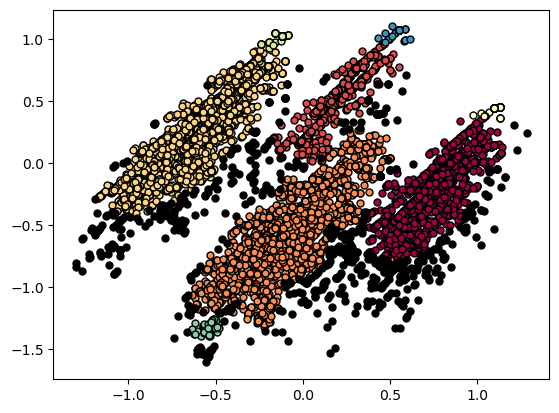

In [53]:
from sklearn.cluster import DBSCAN

# Assuming your data is in a NumPy array named 'data'
clustering = DBSCAN(eps=0.09, min_samples=60).fit(pca_components)

# Get the cluster labels for each data point
labels_db = clustering.labels_

# Create a color palette for the clusters
unique_labels = set(labels_db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Plot the data points with different colors for each cluster
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_members = [i for i in range(len(labels_db)) if labels_db[i] == k]
    xy = pca_components[class_members]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=5)

plt.show()

#### *finding the best parameters*

In order to find the correct parameters for eps and min_samples, an elbow plot should have been used. However, since we decided it was not crucial, we manually verified many parameters and returned the one that showed the 4 clusters we wanted the data to be divided into, with as few black dots as possible. The black dots represent movies that do not belong to any categories, therefore they are considered outliers.

#### *Differences*

This algorithm is vastly different from what we built from scratch. It can create clusters without an initial input for the number of clusters, meaning that it is not susceptible to issues related to selecting the wrong number of clusters. As seen from the clustering done above, it has its own disadvantages. After the substantial data loss from missing tag relevance values, DBSCAN removes more data points as they do not seem to be part of any cluster, but it can be observed that these are just edge cases of the main cluster.  

Going back to the ability to cluster without centroids, this gives the algorithm the advantage of clustering the group of movies based on score similarity rather than distance from each other. This alleviates the problem of the data not being linearly correlated and makes it more efficient in capturing the nonlinear differences.

### **2.4 Best Algorithm**

Converged after 23 iterations.
Converged after 19 iterations.


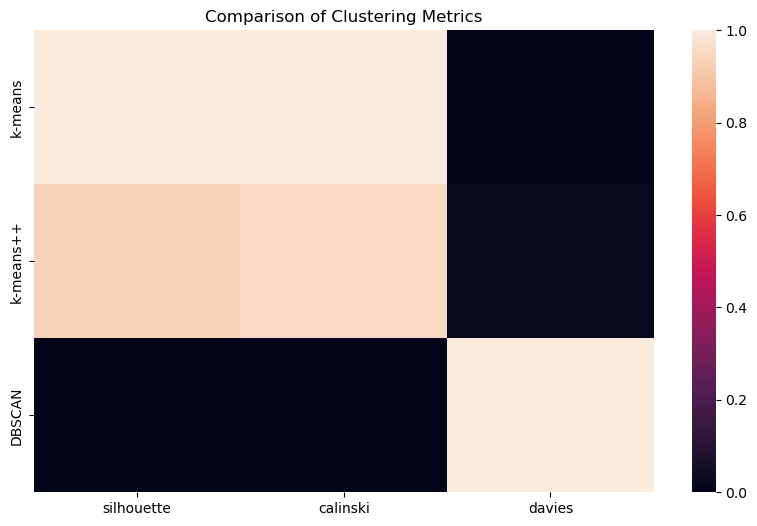

In [54]:
# Define the number of clusters based on previous analysis (you can adjust this value)
k = 10

# Running K-means on PCA components
labels, centroids_pp = kmeans(pca_components, K)

# Running K-means++ on PCA components
labels_pp, centroids_pp = kmeans_plus_plus(pca_components, K)

# DBSCAN
dbscan = DBSCAN(eps=0.09, min_samples=60)
labels_db = dbscan.fit_predict(pca_components)


# First comparison method, the silhouette score since it is verry verastile it can also be used to compare clustering

silhouette_kmeans = silhouette_score(pca_components, labels)
silhouette_kmeans_plus = silhouette_score(pca_components, labels_pp)
silhouette_dbscan = silhouette_score(pca_components, labels_db)

# Second comparison methos, the ARI compares clustering with ground truth, considering chance.

from sklearn.metrics import calinski_harabasz_score

ch_kmeans = calinski_harabasz_score(pca_components, labels)
ch_kmeans_plus = calinski_harabasz_score(pca_components, labels_pp)
ch_dbscan = calinski_harabasz_score(pca_components, labels_db)

# Third comparison, the Davies-Bouldin Index evaluates how distinct the clusters are.
from sklearn.metrics import davies_bouldin_score

dbi_kmeans = davies_bouldin_score(pca_components, labels)
dbi_kmeans_plus = davies_bouldin_score(pca_components, labels_pp)
dbi_dbscan = davies_bouldin_score(pca_components, labels_db)


result_dataframe = {"silhouette" : [silhouette_kmeans, silhouette_kmeans_plus, silhouette_dbscan],
                    "calinski" : [ch_kmeans, ch_kmeans_plus, ch_dbscan],
                    "davies" : [dbi_kmeans, dbi_kmeans_plus, dbi_dbscan]}

result_dataframe = pd.DataFrame.from_dict(result_dataframe)
result_dataframe.index = ["k-means", "k-means++", "DBSCAN"]

# Apply Min-Max normalization across columns (fit on the data and transform)
result_normalized = minmax_scale(result_dataframe)

# Convert the result back into a DataFrame with the same columns as the original DataFrame
result_dataframe = pd.DataFrame(result_normalized, columns=result_dataframe.columns, index=result_dataframe.index)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.heatmap(data= result_dataframe)
plt.title("Comparison of Clustering Metrics")
plt.show()

The output of the clustering algorithms, K-means, K-means++, and DBSCAN, shows that K-means and K-means++ outperformed DBSCAN across all three metrics. K-means achieved the highest silhouette value, indicating that its cluster cohesion is high and well-separated, while the Davies-Bouldin index is very low, reflecting compact clusters with minimal overlap. K-means++ performs slightly better than K-means, with a silhouette score close to the maximum and the best possible Calinski-Harabasz value, indicating that the cluster separation is very well-defined.  

On the other hand, DBSCAN has low values: a minimum silhouette score indicates very poor cohesion or separation between clusters, and the low value of the Calinski-Harabasz index corresponds to no meaningful clusters. Its peak in the Davies-Bouldin index suggests that DBSCAN fails to separate the clusters, probably treating most of the points as noise. These results indicate that both K-means and K-means++ work better on the current dataset, most likely because it contains clearly separated and well-defined clusters. DBSCAN, on the other hand, does not support this scenario.

#### Bonus Question

The method used to determine the features in this exercise is **Principal Component Analysis (PCA)**.

PCA is a dimensionality reduction technique that transforms a set of correlated variables into a new set of uncorrelated variables called **principal components**. The principal components are ordered such that the first principal component (PC1) captures the maximum variance in the dataset, the second principal component (PC2) captures the second highest variance, and so on. Hence **PC1 and PC2** are the first two principal components, which represent the directions in which the data varies the most. These two components were chosen to create a 2D representation of the data, which can be easily visualized in a 2D plot. The idea is that, through PCA, the data is reduced in such a way that the remaining dimensions do not introduce significant variability, thus making it easier to identify clusters in the data.



Converged after 17 iterations.


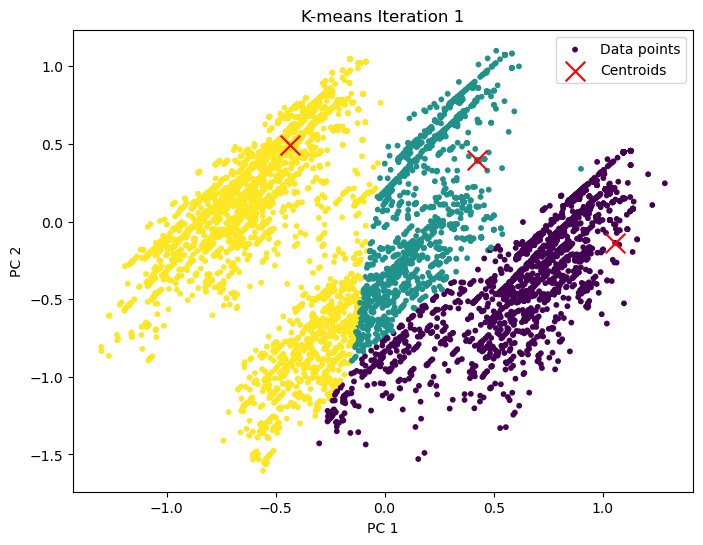

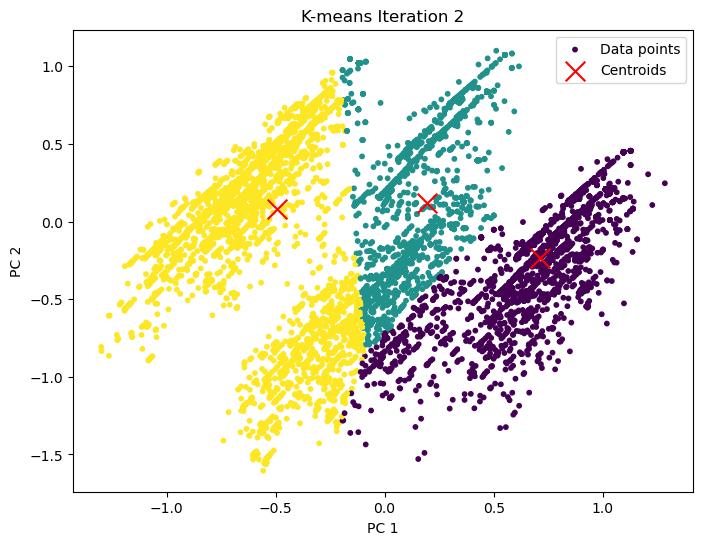

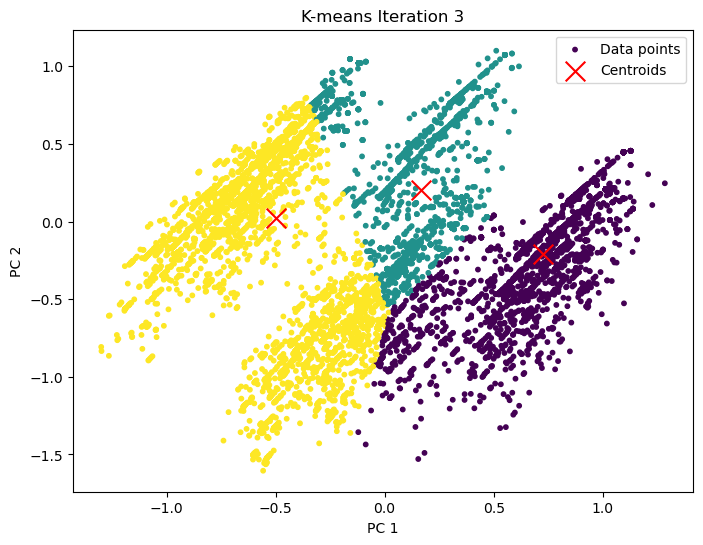

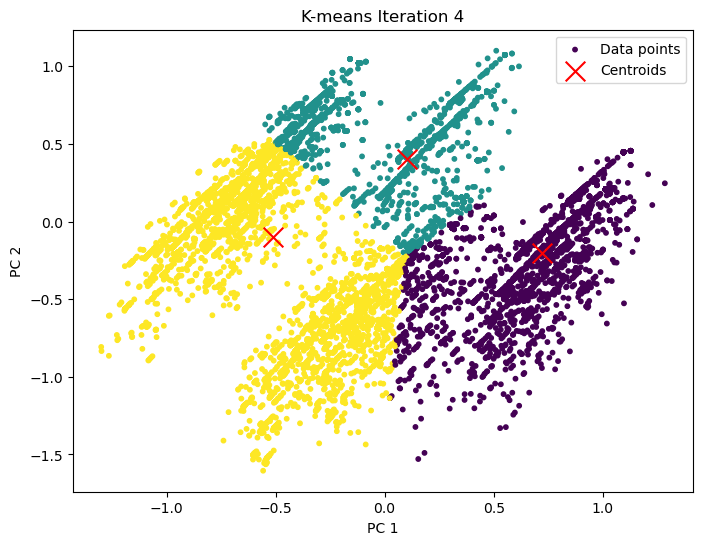

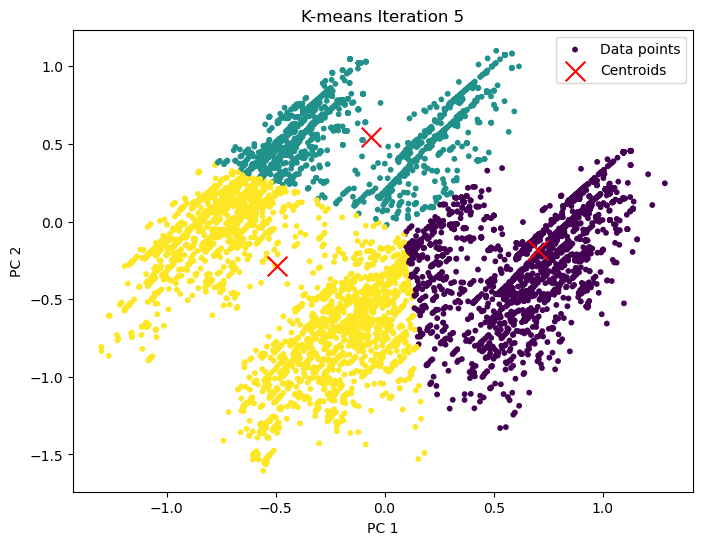

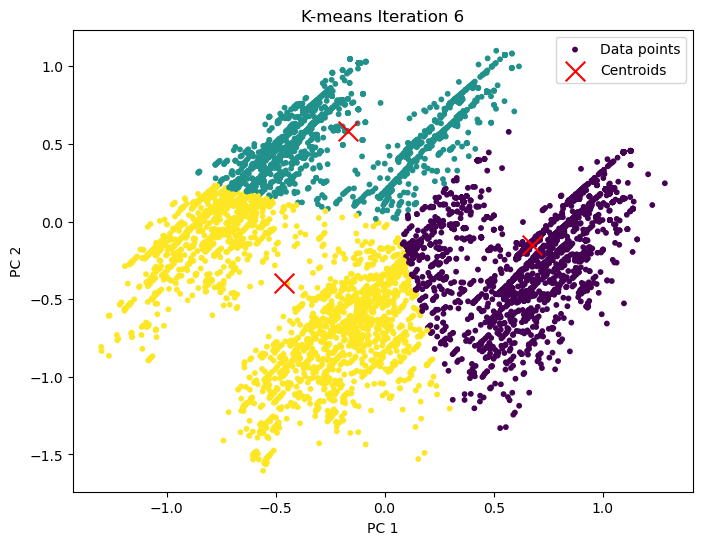

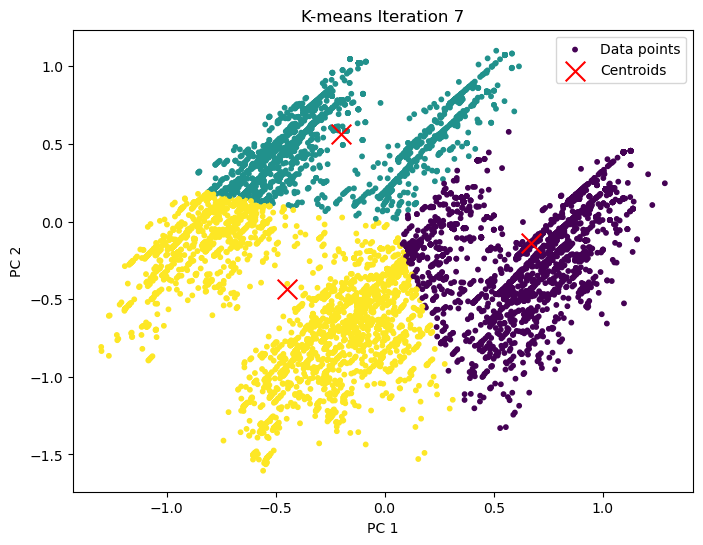

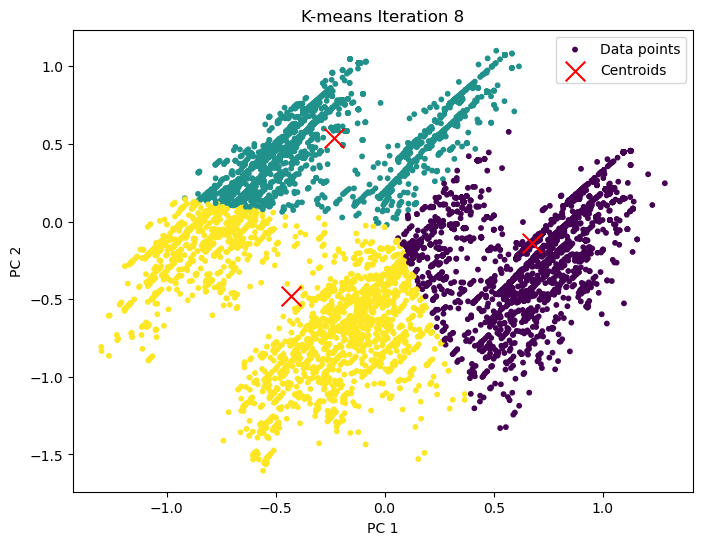

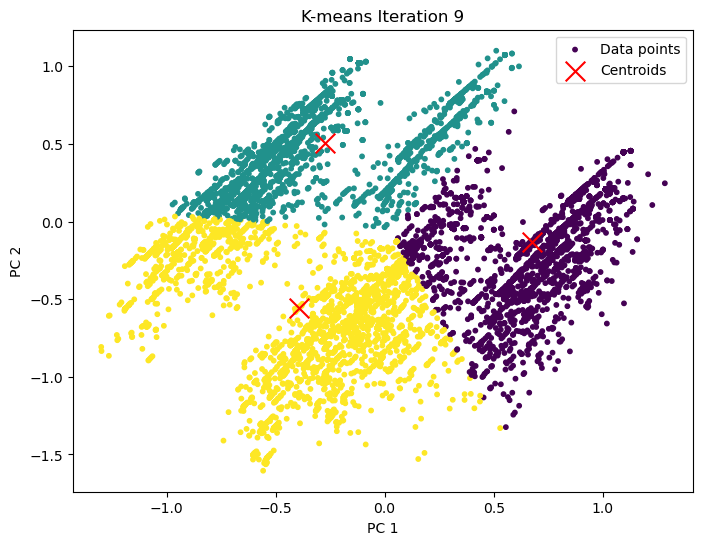

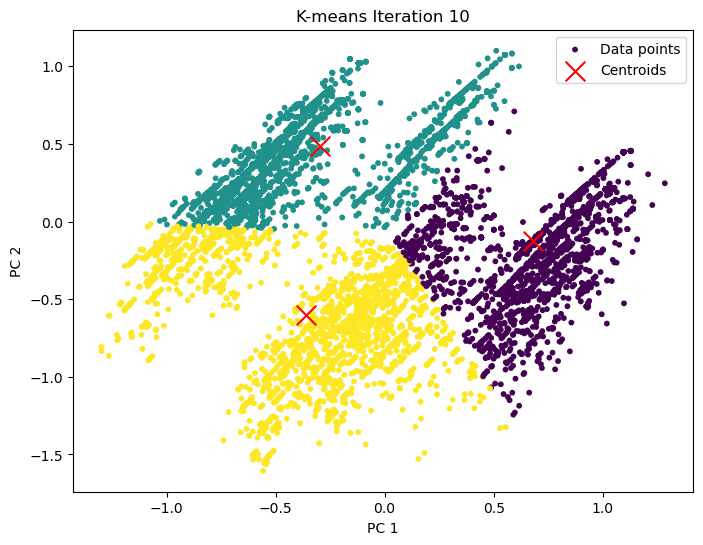

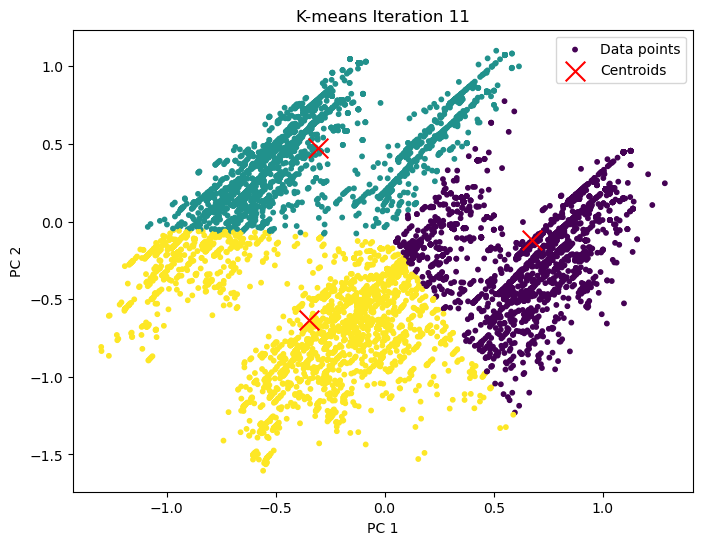

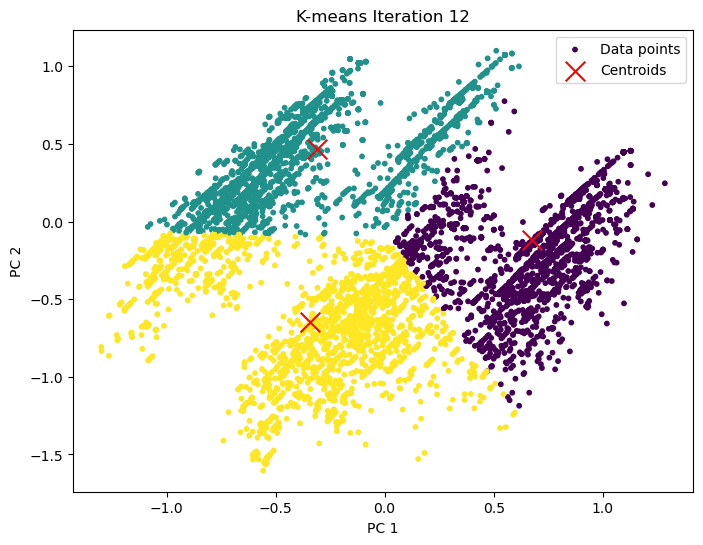

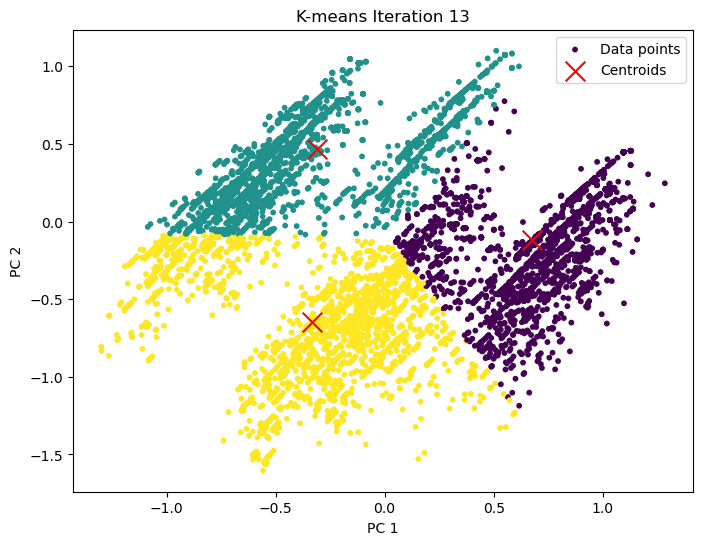

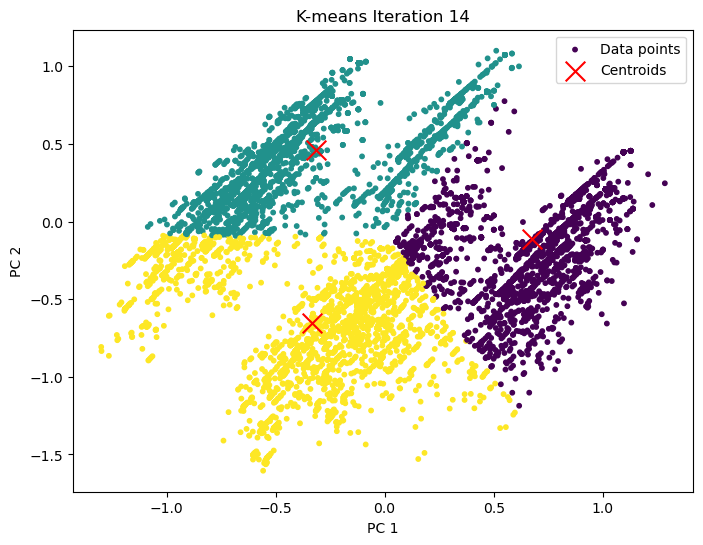

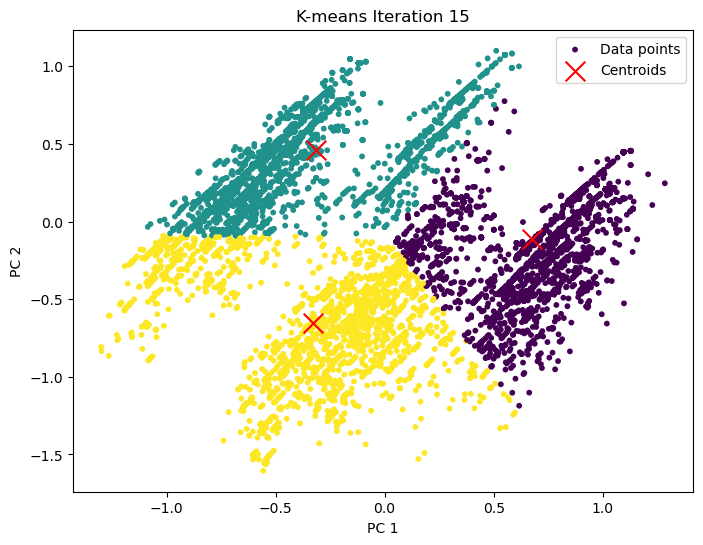

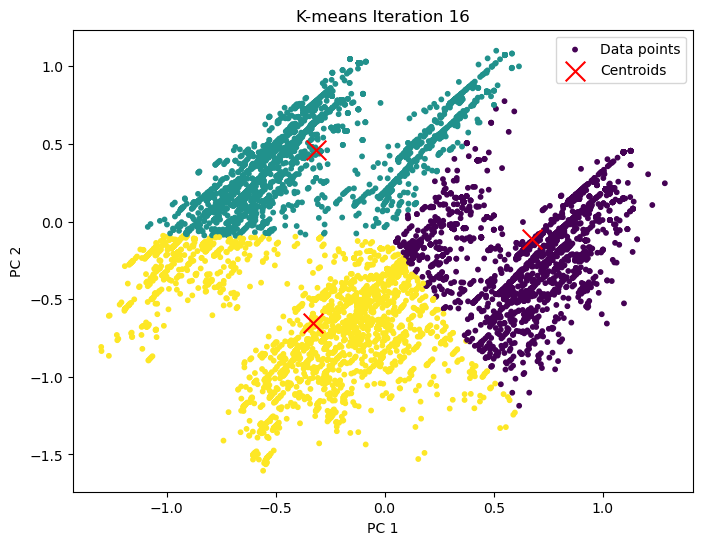

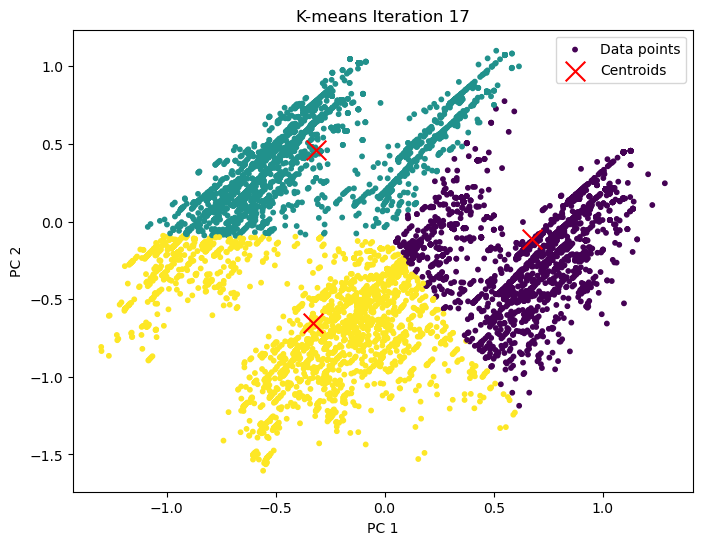

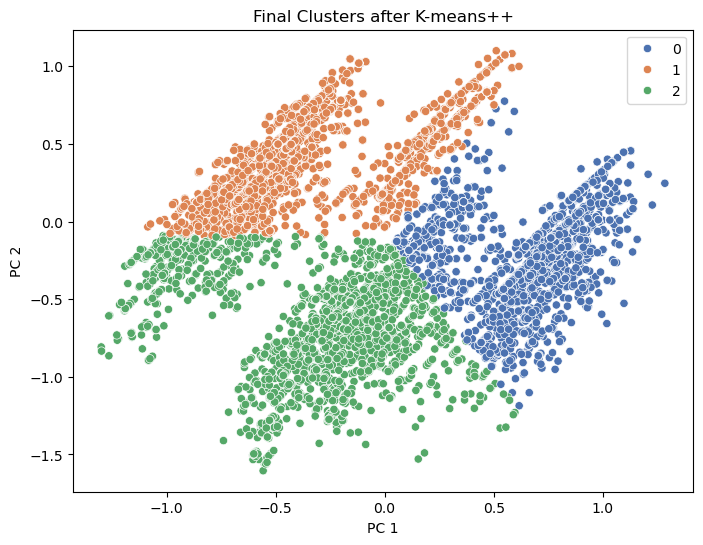

In [55]:
# Function to execute K-means++ and visualize the evolution of clusters
def kmeans_plus_plus(data, K, max_iterations=25):
    # Initialize the centroids using K-means++
    centroids = kmeans_plus_plus_init(data, K)
    history = []  # To store the states at each iteration

    for i in range(max_iterations):
        # Assign the clusters
        labels = assign_clusters(data, centroids)

        # Update the centroids
        new_centroids = update_centroids(data, labels, K)

        # Save the states (centroids and labels) to visualize the progress
        history.append((centroids, labels))

        # Check for convergence (if the centroids do not change anymore)
        if np.allclose(new_centroids, centroids):
            print(f"Converged after {i+1} iterations.")
            break

        centroids = new_centroids

    return history

# Run K-means++ and track the evolution
K = 3  # Number of clusters
history = kmeans_plus_plus(pca_components, K)

# Visualize the progress of clustering at each iteration
for i, (centroids, labels) in enumerate(history):
    plt.figure(figsize=(8, 6))
    # Plot the data points, colored by their cluster labels
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis', s=10, label='Data points')
    # Plot the centroids with red 'X' markers
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label='Centroids')
    plt.title(f"K-means Iteration {i+1}")
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()
    plt.show()

# Final plot after all iterations
plt.figure(figsize=(8, 6))
# Plot the final clusters with seaborn, using the last labels
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels, palette="deep")
plt.title('Final Clusters after K-means++')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
